In [2]:
%%time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import keras_metrics
from keras.layers import Activation
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

import pyswarms as ps
from imutils import paths
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

print(f"[INFO] Libraries imported")

[INFO] Libraries imported
CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 3.9 ms


### DATA PREPARATION ##########################################################################################

Loads dataset images and defines some important variables to use in next steps.

In [3]:
%%time

#Dataset folder
dataset_folder = "dataset/"

#Initialize the data matrix and labels list
data = []
labels = []

#Number of classes
n_classes = 2

#Resize parameter to transform image
resize_values = (32, 32)

#Grab the list of images that we'll be describing
images_paths = list(paths.list_images(dataset_folder))

#Gets the dataset dimension
number_of_images = len(images_paths)

print(f"[INFO] {number_of_images} images loaded from '{dataset_folder}'")

[INFO] 25000 images loaded from 'dataset/'
CPU times: user 79.4 ms, sys: 22.5 ms, total: 102 ms
Wall time: 101 ms


Processes all images in dataset, resizing and extracting features vectors and classes labels

In [4]:
%%time

print(f"[INFO] Starting processing of {number_of_images} images")

#Processing current percentage
percentage = 0

#Loop over the input images
for (i, image_path) in enumerate(images_paths):
    
    #Loads the current image
    image = cv2.imread(image_path)
    
    #Extract object label by image name
    label = image_path.split(os.path.sep)[-1].split(".")[0]
    labels.append(label)
    
    #Construct a features vector trough the current image
    features = cv2.resize(image, resize_values).flatten()
    data.append(features)
    
    #Gets the processing percentage
    old_percentage = percentage
    percentage = ((i + 1) * 100) // number_of_images
    
    #Shows the processing progress
    if (percentage > 0) and (percentage % 10 == 0) and (percentage != old_percentage):
        print(f"  {percentage}% of images are processed")
    
#Shows that the process was finished
print(f"[INFO] Processing finished")

[INFO] Starting processing of 25000 images
  10% of images are processed
  20% of images are processed
  30% of images are processed
  40% of images are processed
  50% of images are processed
  60% of images are processed
  70% of images are processed
  80% of images are processed
  90% of images are processed
  100% of images are processed
[INFO] Processing finished
CPU times: user 2min 1s, sys: 5.56 s, total: 2min 7s
Wall time: 6min 56s


Shows a example of dataset image in normal size, resized and respective label.

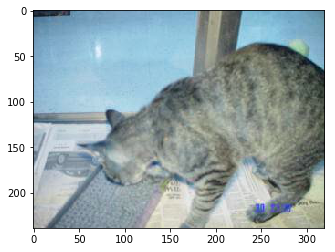

In [5]:
#Shows default image
plt.imshow(image)

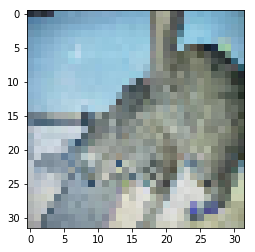

In [6]:
#Shows resized image
plt.imshow(cv2.resize(image, resize_values))

In [7]:
#Shows the label of image presented above
label

'cat'

Encodes string labels to numeric labels.

In [8]:
#Transforms string labels to numeric labels [0: cat, 1: dog]
encoded_labels = LabelEncoder().fit_transform(labels)

#Transforms numeric labels to categorical data
encoded_labels = np_utils.to_categorical(encoded_labels, n_classes)

In [9]:
#Shows the transformed label 
encoded_labels[number_of_images - 1]

array([1., 0.], dtype=float32)

Normalizes images feature vectors form 0-255 to 0-1

In [10]:
#Shows the image features vector [0 to 255]
data[0]

array([ 86, 123, 179, ..., 234, 229, 228], dtype=uint8)

In [11]:
#Normalizes the dataset images feature vector [0 to 1]
data = np.array(data) / 255.0

In [12]:
#Shows the image features vector [0 to 1]
data[0]

array([0.3372549 , 0.48235294, 0.70196078, ..., 0.91764706, 0.89803922,
       0.89411765])

Splits dataset in train = 50%, validation = 25% and test = 25%.

In [ ]:
#Splits default dataset in 50% train and 50% test and validation
(train_x, test_val_x, train_y, test_val_y) = train_test_split(data, encoded_labels, test_size = 0.50, random_state=42)

In [ ]:
#Splits test/validation dataset in 50% test and 50% validation and validation
(test_x, val_x, test_y, val_y) = train_test_split(test_val_x, test_val_y, test_size = 0.50, random_state=42)

### MLP MODEL DEFINITION AND CONFIGURATION ##########################################################################################

Defines a function to create a keras sequential model, aka MLP.

In [ ]:
#Creates a MLP model
def create_model(input_layer=3072, first_hidden_layer=768, second_hidden_layer=512, output_layer=2):
    #Sequential MLP
    model = Sequential()
    
    #Defines input layer and the first hidden layer
    model.add(Dense(first_hidden_layer, input_dim = input_layer, init = "uniform", activation = "relu"))
    
    #Defines second hidden layer
    model.add(Dense(second_hidden_layer, activation = "relu", kernel_initializer = "uniform"))
    
    #Defines output layer
    model.add(Dense(output_layer))
    
    #Defines a output perceptron that gives the prediction percentage
    model.add(Activation("softmax"))
    
    #Compiles the MLP model
    model.compile(loss = "binary_crossentropy", optimizer = SGD(lr = 0.1), 
                  metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])

    return model

#Input layer perceptron number
input_layer = len(data[0])

#Output layer perceptron number
output_layer = n_labels

#Train/validation epochs
epochs = 50

#Train/validation batch size 
batch_size = 128

#Create model
model = KerasClassifier(build_fn = create_model, epochs = epochs, batch_size = batch_size, verbose = 1)

### BEST MLP MODEL CHOOSE THROUGH GRID SEARCH

Defines MLP hyperparameters attached by GridSearch and search for best model through this algorithm.

In [ ]:
%%time

#Define the grid search parameter as training optimization algorithm
gs_param_grid = {
    "input_layer": [input_layer],
    "first_hidden_layer": [(input_layer // 2), (input_layer // 4)],
    "second_hidden_layer": [(input_layer // 6), (input_layer // 8)],
    "output_layer": [output_layer]
}

#Define cross validation type
cross_validation = 3

#Defines parallel process
parallel_process = -1

#Creates grid through parameters
grid = GridSearchCV(estimator = model, param_grid = gs_param_grid, n_jobs = parallel_process, 
                    cv = cross_validation, verbose = 1)

#Fit grid models
grid_result = grid.fit(train_x, train_y, validation_data=(val_x, val_y))

Gets best MLP model reached through GridSearch application and process information

In [ ]:
#Gets the best model score
best_score = grid_result.best_score_
    
#Gets model means by parameters
means = grid_result.cv_results_['mean_test_score']

#Gets model stds by parameters
stds = grid_result.cv_results_['std_test_score']

#Gets model parameters
params = grid_result.cv_results_['params']

#Shows values
print("[INFO] Grid search results\n  1st hidden layer\t2nd hidden layer\tMean score\t\tStd score")
for mean, stdev, param in zip(means, stds, params):
    info = f"  {param['first_hidden_layer']}\t\t\t{param['second_hidden_layer']}\t\t\t{mean}\t{stdev}"
    if grid_result.best_score_ == mean:
        info = info + "  <-- Best parameters"
    print(info)

Gets GridSearch best model train history, evaluates the model with test dataset and save test metrics.

In [ ]:
#Gets the grid search best model
gs_best_model = grid_result.best_estimator_.model

#Creates a dictionary with epochs and train/validation metrics
gs_history = {"epochs" : list(range(1, epochs + 1))}
GridSearchgs_history.update(gs_best_model.history.history)

#Tranforms dictionary into a pandas dataframe
gs_history = pd.DataFrame(gs_history)
gs_history = gs_history.set_index(["epochs"])

#Gets test metrics and puts in a series
gs_test_metrics = gs_best_model.evaluate(test_x, test_y, batch_size = batch_size, verbose = 1)


Shows GridSearch MLP model configuration and train history.

In [ ]:
#Model info
gs_best_model.summary()

In [ ]:
#Shows history plot
gs_history.plot(y = ['loss', 'acc', 'precision', 'recall', 'f1_score'], figsize=(10,10))

Gets GridSearch MLP model train and validation metrics and merge with test metrics in a dataframe.

In [ ]:
#Gets train/validation metrics
gs_train_val_metrics = gs_history.loc[epochs]

#Gets train metrics
gs_train_metrics = gs_train_val_metrics[5:10]

#Gets validation metrics
gs_val_metrics = gs_train_val_metrics[0:5]
gs_val_metrics = gs_val_metrics.rename(index={"val_loss": "loss", 
            Gets                         "val_acc": "acc",
                                     "val_precision": "precision",
                                     "val_recall": "recall",
                                     "val_f1_score": "f1_score"})

#Gets test metrics
gs_test_metrics = pd.Series(dict(zip(gs_best_model.metrics_names, gs_test_metrics)))

#Gets grid search metrics
gs_metrics = pd.DataFrame([gs_train_metrics, gs_val_metrics, gs_test_metrics], 
                          index = ["train", "validation", "test"])

In [ ]:
#Shows metrics reached in train, validation and test datasets
gs_metrics

Saves GridSearch best MLP model, train history, and train, validation and test metrics in files.

In [ ]:
#Saves grid search best model
gs_best_model.save("models/gs_best_model.hdf5")

#Saves grid search best model history
gs_history.to_csv("metrics/gs_best_model_hist.csv")

#Saves grid search best model metrics
gs_metrics.to_csv("metrics/gs_best_model_metrics.csv")

### BEST MLP MODEL CHOOSE THROUGH PSO

Defines the PSO fitness fuction which trains MLP models through defined particles.

In [ ]:
#PSO fitness function
def fitness(hidden_layers, train_x, train_y, val_x, val_y, epochs, batch_size, model_data):  
    
    #Best cost for all particules on interation
    best_cost = 1.0
    
    #Loop over all particules
    for particle_hidden_layers in hidden_layers:
        
        #Shows MLP hyperparameters saved in current particule
        print(f"\n[INFO]Particule 1st hidden layer: {int(particle_hidden_layers[0])} and 2nd hidden layer: {int(particle_hidden_layers[1])}")
        
        #Creates a MLP model composed by particule data
        model = create_model(first_hidden_layer=int(particle_hidden_layers[0]), 
                             second_hidden_layer=int(particle_hidden_layers[1]))
        
        #Fits the current particule MLP model
        metrics = model.fit(train_x, train_y, validation_data = (val_x, val_y),
                               epochs = epochs, batch_size = batch_size)
        
        #Gets train accuracy
        acc = metrics.history['acc'][epochs - 1]
        
        #Gets particule cost
        cost = 1 - acc
        
        #Checks if current particule has the best iteration cost
        if cost < best_cost:
            #Changes the best iteration cost
            best_cost = cost
        
        #Checks if current particule has the best cost of all iterations
        if cost < model_data[0]["cost"]:
            #Gets the best cost, model and history
            model_data[0] = {"cost": cost, "model": model, "history": metrics.history}
                GridSearch
        #Shows particule cost
        print(f"[INFO] Particule cost: {cost}")
                        
    return best_cost

Configures PSO algorithm with GBest and find the best MLP model.

In [ ]:
# Create bounds
max_bound = np.array([(input_layer // 2), (input_layer // 6)])
min_bound = np.array([(input_layer // 4), (input_layer // 8)])
bounds = (min_bound, max_bound)

#Set PSO hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

#Number of particles
n_particles = 3

#Number of dimensions
dimensions = 2

#Number of iterations
iterations = 4

#Creates optmizer
optimizer = ps.single.GlobalBestPSO(n_particles = n_particles, dimensions = dimensions, 
                                    options = options, bounds = bounds)
GetsGets
#Saves best PSO model data
model_data = [{"cost": 1.0, "model": None, "history": None}]

#Executes PSO
cost, pos = optimizer.optimize(fitness, iters = iterations, train_x = train_x, train_y = train_y, val_x = val_x, 
                               val_y = val_y, epochs = epochs, batch_size = batch_size, model_data = model_data)

Gets PSO best model train history, evaluates the model with test dataset and save test metrics.

In [ ]:
#Gets the PSO best model
pso_best_model = model_data[0]["model"]

#Creates a dictionary with epochs and train/validation metricsGets
pso_history = {"epochs" : list(range(1, epochs + 1))}
pso_history.update(model_data[0]["history"])

#Tranforms dictionary into a pandas dataframe
pso_history = pd.DataFrame(pso_history)
pso_history = pso_history.set_index(["epochs"])

#Gets test metrics and puts in a series
pso_test_metrics = pso_best_model.evaluate(test_x, test_y, batch_size = batch_size, verbose = 1)

Shows PSO MLP model configuration and train history.

In [ ]:
#Model infoGets GridSearch MLP model train and validation metrics and merge with test metrics in a dataframe.
pso_best_model.summary()

In [ ]:
#Shows history plot
pso_history.plot(y = ['loss', 'acc', 'precision', 'recall', 'f1_score'], figsize=(10,10))

Gets PSO MLP model train and validation metrics and merge with test metrics in a dataframe.

In [ ]:
#Gets train/validation metrics
pso_train_val_metrics = pso_history.loc[epochs]

#Gets train metrics
pso_train_metrics = pso_train_val_metrics[5:10]

#Gets validation metrics
pso_val_metrics = pso_train_val_metrics[0:5]
pso_val_metrics = pso_val_metrics.rename(index={"val_loss": "loss", 
                                     "val_acc": "acc",
                                     "val_precision": "precision",
                                     "val_recall": "recall",
                                     "val_f1_score": "f1_score"})

#Gets test metrics
pso_test_metrics = pd.Series(dict(zip(["loss", "acc", "precision", "recall", "f1_score"], pso_test_metrics)))

#Gets grid search metrics
pso_metrics = pd.DataFrame([pso_train_metrics, pso_val_metrics, pso_test_metrics], 
                          index = ["train", "validation", "test"])

In [ ]:
#Shows metrics reached in train, validation and test datasets
pso_metrics

Saves PSO best MLP model, train history, and train, validation and test metrics in files.

In [ ]:
#Saves PSO best model
pso_best_model.save("models/pso_best_model.hdf5")

#Saves PSO best model history
pso_history.to_csv("metrics/pso_best_model_hist.csv")

#Saves PSO best model metrics
pso_metrics.to_csv("metrics/pso_best_model_metrics.csv")

### GRID SEARCH AND PSO MODELS COMPARISSON

Loads best GridSearch and PSO models train/validation history from files and creates a dataframe.

In [13]:
#Loads grid search model history
gs_model_history = pd.read_csv("metrics/gs_best_model_hist.csv")

#Loads PSO model history
pso_model_history = pd.read_csv("metrics/pso_best_model_hist.csv")

#Creates a history dataframe
gs_pso_comparison = pd.DataFrame()

#Puts grid search and pso models history on dataframe
gs_pso_comparison["epochs"] = gs_model_history["epochs"]
gs_pso_comparison["gs_loss"] = gs_model_history["loss"]
gs_pso_comparison["gs_acc"] = gs_model_history["acc"]
gs_pso_comparison["gs_precision"] = gs_model_history["precision"]
gs_pso_comparison["gs_recall"] = gs_model_history["recall"]
gs_pso_comparison["gs_f1_score"] = gs_model_history["f1_score"]
gs_pso_comparison["pso_loss"] = pso_model_history["loss"]
gs_pso_comparison["pso_acc"] = pso_model_history["acc"]
gs_pso_comparison["pso_precision"] = pso_model_history["precision"]
gs_pso_comparison["pso_recall"] = pso_model_history["recall"]
gs_pso_comparison["pso_f1_score"] = pso_model_history["f1_score"]

#Sets epochs as index
gs_pso_comparison = gs_pso_comparison.set_index("epochs")

Plots train history for all used metrics.

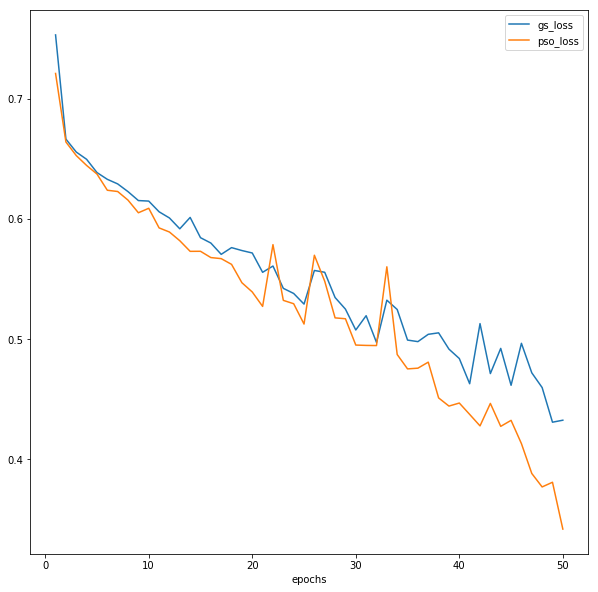

In [14]:
#Loss comparison plot
gs_pso_comparison.plot(y=["gs_loss", "pso_loss"], figsize=(10,10))

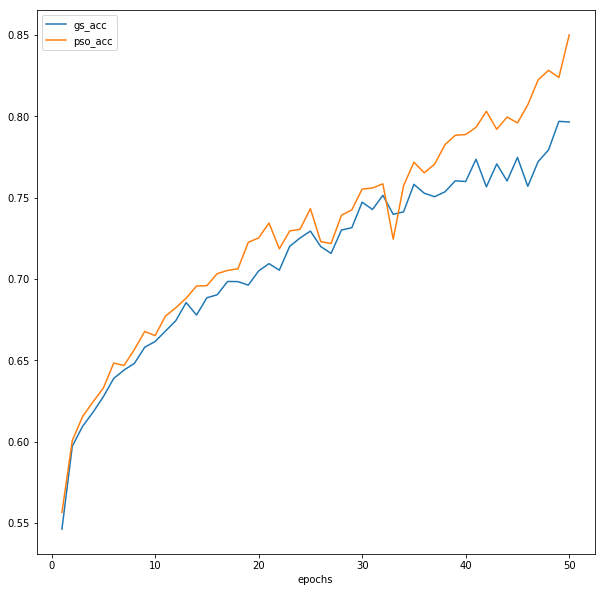

In [15]:
#Accuracy comparison plot
gs_pso_comparison.plot(y=["gs_acc", "pso_acc"], figsize=(10,10))

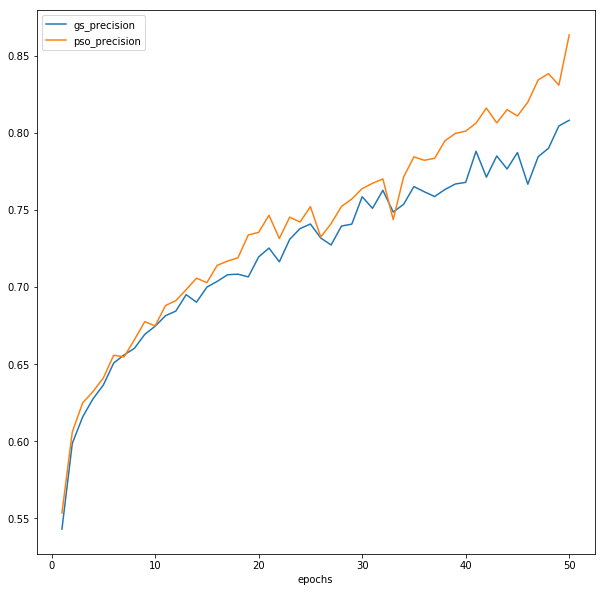

In [16]:
#Precision comparison plot
gs_pso_comparison.plot(y=["gs_precision", "pso_precision"], figsize=(10,10))

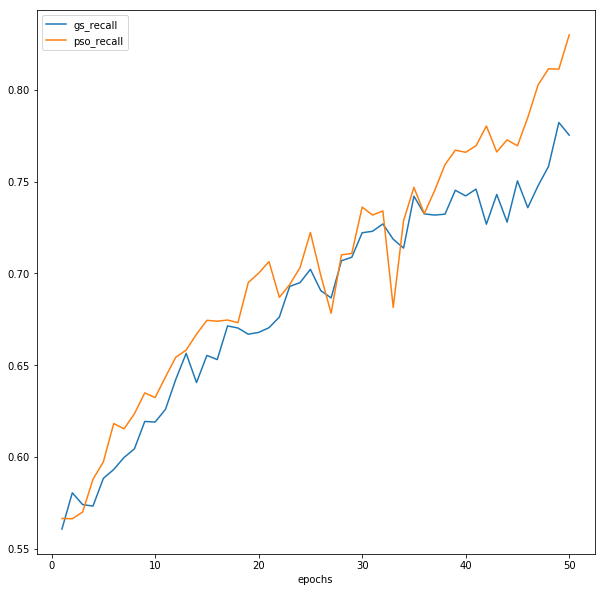

In [17]:
#Recall comparison plot
gs_pso_comparison.plot(y=["gs_recall", "pso_recall"], figsize=(10,10))

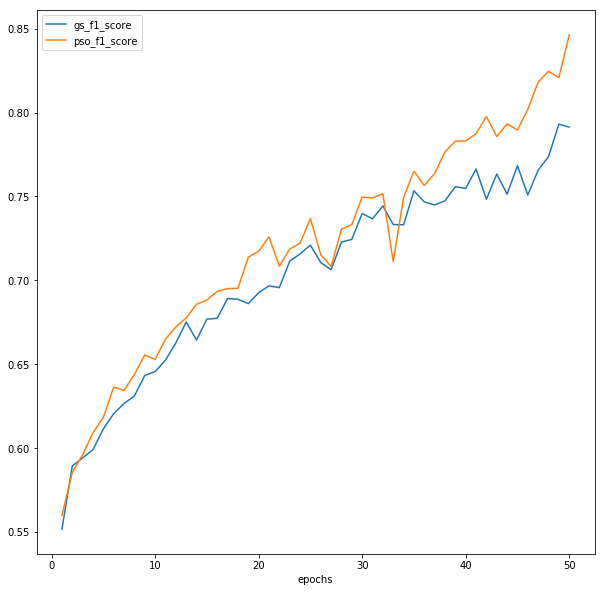

In [18]:
#F1 score comparison plot
gs_pso_comparison.plot(y=["gs_f1_score", "pso_f1_score"], figsize=(10,10))

Loads best GridSearch and PSO models final metrics from files and creates a dataframe.

In [19]:
#Loads grid search best model metrics from file
gs_model_metrics = pd.read_csv("metrics/gs_best_model_metrics.csv")

#Loads PSO best model metrics from file
pso_model_metrics = pd.read_csv("metrics/pso_best_model_metrics.csv")

#Creates metrics dataframe
gs_pso_metrics = pd.DataFrame()

#Puts grid search and pso models metrics on dataframe
gs_pso_metrics["dataset"] = pd.Series(["train", "validation", "test"])
gs_pso_metrics["gs_loss"] = gs_model_metrics["loss"]
gs_pso_metrics["gs_acc"] = gs_model_metrics["acc"]
gs_pso_metrics["gs_precision"] = gs_model_metrics["precision"]
gs_pso_metrics["gs_recall"] = gs_model_metrics["recall"]
gs_pso_metrics["gs_f1_score"] = gs_model_metrics["f1_score"]
gs_pso_metrics["pso_loss"] = pso_model_metrics["loss"]
gs_pso_metrics["pso_acc"] = pso_model_metrics["acc"]
gs_pso_metrics["pso_precision"] = pso_model_metrics["precision"]
gs_pso_metrics["pso_recall"] = pso_model_metrics["recall"]
gs_pso_metrics["pso_f1_score"] = pso_model_metrics["f1_score"]

#Sets dataset as index
gs_pso_metrics = gs_pso_metrics.set_index(["dataset"])

Plots models final metrics.

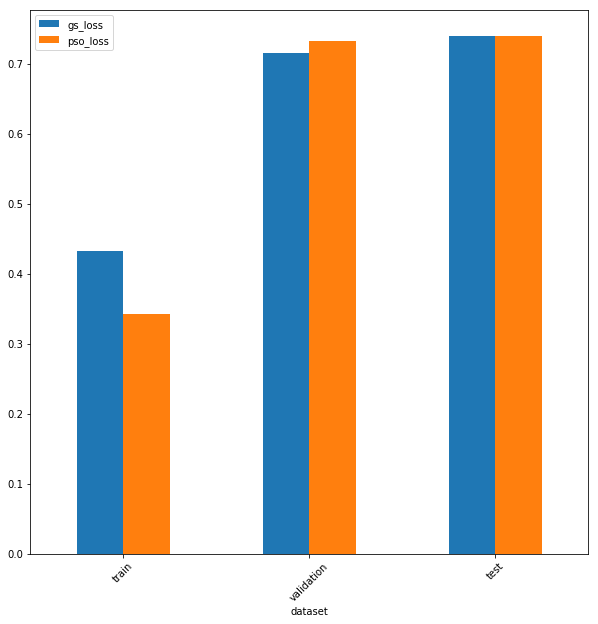

In [20]:
#Loss comparison plot
gs_pso_metrics.plot(kind="bar", y=["gs_loss", "pso_loss"], figsize=(10,10), rot=45)

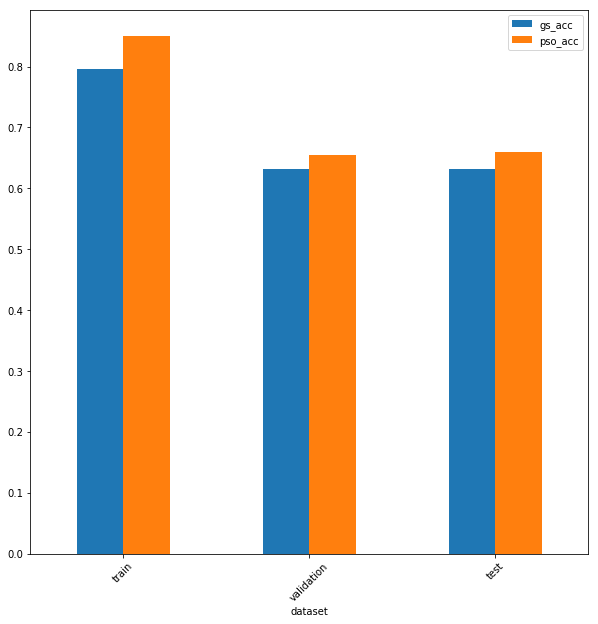

In [21]:
#Accuracy comparison plot
gs_pso_metrics.plot(kind="bar", y=["gs_acc", "pso_acc"], figsize=(10,10), rot=45)

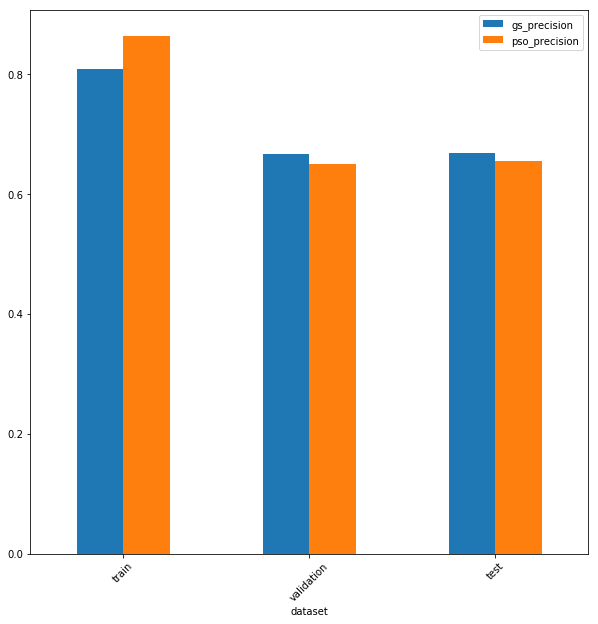

In [22]:
#Precision comparison plot
gs_pso_metrics.plot(kind="bar", y=["gs_precision", "pso_precision"], figsize=(10,10), rot=45)

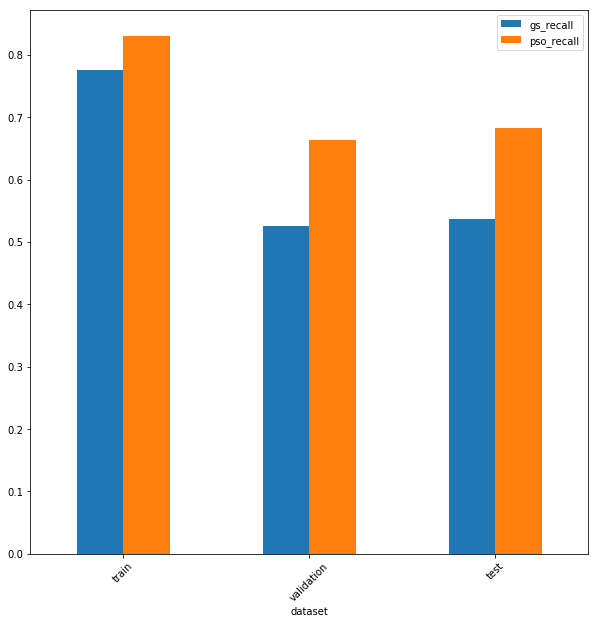

In [23]:
#Recall comparison plot
gs_pso_metrics.plot(kind="bar", y=["gs_recall", "pso_recall"], figsize=(10,10), rot=45)

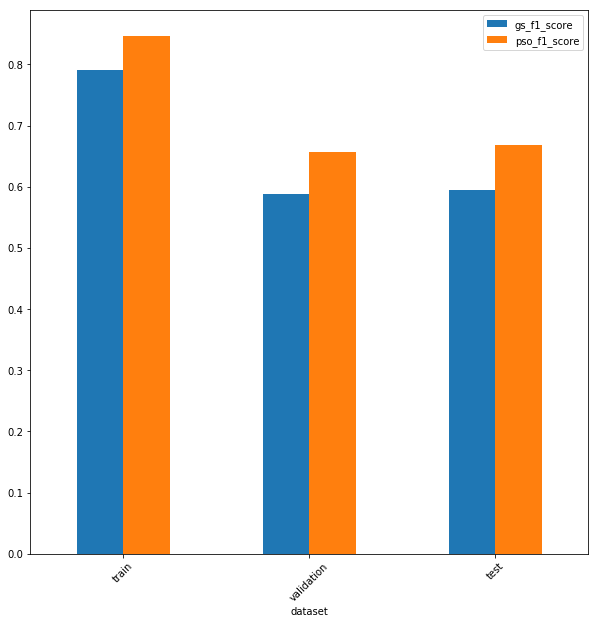

In [24]:
#F1 score comparison plot
gs_pso_metrics.plot(kind="bar", y=["gs_f1_score", "pso_f1_score"], figsize=(10,10), rot=45)

Loads GridSearch and PSO models from their respective files.

In [25]:
#Loads GridSearch model with used metrics
gs_model = load_model("models/gs_best_model.hdf5", 
                      custom_objects={
                          "binary_precision": keras_metrics.precision(),
                          "binary_recall": keras_metrics.recall(),
                          "binary_f1_score": keras_metrics.f1_score()
                      })

#Loads PSO model with used metrics
pso_model = load_model("models/pso_best_model.hdf5", 
                      custom_objects={
                          "binary_precision": keras_metrics.precision(),
                          "binary_recall": keras_metrics.recall(),
                          "binary_f1_score": keras_metrics.f1_score()
                      })

In [26]:
#Shows grid search MLP model architecture
gs_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 768)               2360064   
_________________________________________________________________
dense_17 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 2,754,818
Trainable params: 2,754,818
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Shows PSO MLP model architecture
pso_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 928)               2851744   
_________________________________________________________________
dense_35 (Dense)             (None, 425)               394825    
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 852       
_________________________________________________________________
activation_12 (Activation)   (None, 2)                 0         
Total params: 3,247,421
Trainable params: 3,247,421
Non-trainable params: 0
_________________________________________________________________


Classifies images allowing GridSearch and PSO models efficiency visualization.

In [28]:
#Function created to classify a image
def image_classify(classes, model, image):
    #Copy received image
    image = image.copy()
    
    #Resizes and extracts feature vector from image 
    features = cv2.resize(image, resize_values).flatten() / 255.0
    features = np.array([features])
    
    #Gets prediction data
    probs = model.predict(features)[0]
    prediction = probs.argmax(axis=0)
        
    #Creates a final image with classification label
    label = "{}: {:.2f}%".format(classes[prediction],probs[prediction] * 100)
    processed_image = cv2.putText(image, label, (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
    
    return processed_image

#MLP model classes
classes = ["cat", "dog"]

#Loop over all images for classification
for image_path in paths.list_images("classifications/base/"):
    #Extracts image name
    image_name = image_path[image_path.rfind("/") + 1:]
    
    #Reads image
    image = cv2.imread(image_path)
    
    #Processes and saves processed image applying grid search MLP model
    gs_processed_image = image_classify(classes, gs_model, image)
    cv2.imwrite(f"classifications/processed/gs_{image_name}", gs_processed_image)
    
    #Processes and saves processed image applying PSO MLP model
    pso_processed_image = image_classify(classes, pso_model, image)
    cv2.imwrite(f"classifications/processed/pso_{image_name}", pso_processed_image)

Compares the classification of GridSearch and PSO MLP models.

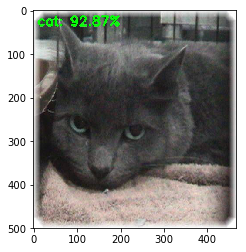

In [29]:
#Shows grid search model cat classification
plt.imshow(cv2.imread("classifications/processed/gs_cat.jpg"))

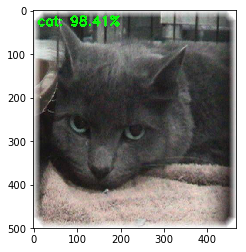

In [30]:
#Shows PSO model cat classification
plt.imshow(cv2.imread("classifications/processed/pso_cat.jpg"))

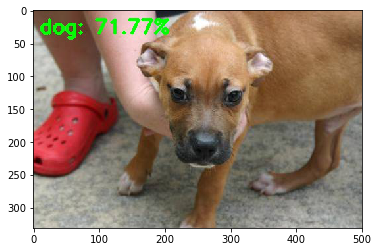

In [33]:
#Shows grid search model dog classification
plt.imshow(cv2.cvtColor(cv2.imread("classifications/processed/gs_dog.jpg"), cv2.COLOR_BGR2RGB))

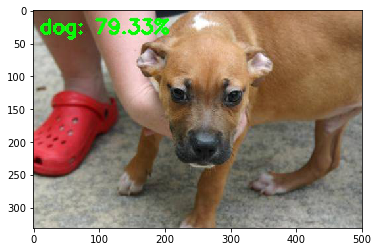

In [34]:
#Shows PSO model dog classification
plt.imshow(cv2.cvtColor(cv2.imread("classifications/processed/pso_dog.jpg"), cv2.COLOR_BGR2RGB))